Add neutrall HSCAN and SW2

In [8]:
import scipy.stats
import statsmodels.api as sm
import statsmodels as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob


os.chdir("/master/nplatt/sch_man_nwinvasion")

# Neutrally evolving loci

## msPrime
Simulate neutral VCFS for each population

I am using the probed MSprime runs from the full dataset but instead randomly downsampling each replicate to 10 indiviudals.  

In [35]:
%%bash

mkdir -p results/msprime/logs

CONDA="conda activate sch_man_nwinvasion-msprime;"
QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 1 "    

for POP in tanzania senegal niger brazil; do
    mkdir results/msprime/$POP
    for I in $(seq 1 100); do
        MSPRIME_CMD="python code/msprime-qsub.py $POP $I"       
        echo "$CONDA $MSPRIME_CMD" | $QSUB -N $POP"_"$I -o results/msprime/logs/$POP"_"$I.log
    done
done


#--------------------------------------------------------------------------------------------------------
# msprime-qsub.py
#--------------------------------------------------------------------------------------------------------

# import msprime
# import os
# import subprocess
# import sys
# from random import randint

# pop = sys.argv[1]
# iteration = sys.argv[2]

# #################################
# def sim_tree(iteration, pop, length, recomb_rate, mut_rate, seed):
    
#     tree_sequence = msprime.simulate( sample_size=n_samples[pop], 
#         Ne=ne[pop], 
#         length=88.9e6, 
#         recombination_rate=3.4e-8,
#         mutation_rate=8.1e-9,
#         random_seed=seed)

#     print("iter {}: {} completed".format(iteration, pop))
#     #print(tree.draw(format="unicode"))

#     with open("results/msprime/{}/chr1_{}_rep_{}_seed_{}.vcf".format(pop, pop, iteration, seed), "w") as vcf_file:
#         tree_sequence.write_vcf(vcf_file, ploidy=2)
# ########################################

# #calcualted by est_pop_params.py
# ne = { "brazil"      : 18293,
#        "niger"       : 19971,
#        "senegal"     : 22421,
#        "tanzania"    : 52234 }

# n_samples = { "brazil"   : 48*2,
#               "senegal"  : 25*2,
#               "niger"    : 10*2,
#               "tanzania" : 58*2  }

# seed = randint(0,1e6)
# sim_tree(iteration, pop, 88e-9, 3.4e-8, 8.1e-9, seed)

Your job 5672368 ("tanzania_1") has been submitted
Your job 5672369 ("tanzania_2") has been submitted
Your job 5672370 ("tanzania_3") has been submitted
Your job 5672371 ("tanzania_4") has been submitted
Your job 5672372 ("tanzania_5") has been submitted
Your job 5672373 ("tanzania_6") has been submitted
Your job 5672374 ("tanzania_7") has been submitted
Your job 5672375 ("tanzania_8") has been submitted
Your job 5672376 ("tanzania_9") has been submitted
Your job 5672377 ("tanzania_10") has been submitted
Your job 5672378 ("tanzania_11") has been submitted
Your job 5672379 ("tanzania_12") has been submitted
Your job 5672380 ("tanzania_13") has been submitted
Your job 5672381 ("tanzania_14") has been submitted
Your job 5672382 ("tanzania_15") has been submitted
Your job 5672383 ("tanzania_16") has been submitted
Your job 5672384 ("tanzania_17") has been submitted
Your job 5672385 ("tanzania_18") has been submitted
Your job 5672386 ("tanzania_19") has been submitted
Your job 5672387 ("ta

Now after all the jobs have finished the through the scheudler take each simulated chrom and extract only the snps that fall within exome-probed regions

In [ ]:
#--------------------------------------------------------------------------------------------------------
# msprime-probe_snps_from_vcf.py
#--------------------------------------------------------------------------------------------------------

import msprime
import os
import subprocess
import glob


#now create bed for the new "sim" chr1
with open('data/renamed-sma_agilent_baits.v7.0.chr_reorderd.bed', 'r') as in_bed:
    with open('results/msprime/sim_probes.bed', 'w') as out_bed:
        for bed_entry in in_bed:
            chrom, start, stop = bed_entry.rstrip().split("\t")
            if chrom == "SM_V7_1":
                out_bed.write("1\t{}\t{}\n".format(start, stop))

bed = 'results/msprime/sim_probes.bed'
#now loop through all of the sim vcf files to get snps at probed regions
for pop in ["niger", "senegal", "tanzania", "brazil"]:
    out_dir = "results/msprime/{}".format(pop)
    
    sim_vcfs = glob.glob("{}/chr1_*_rep_*.vcf".format(out_dir))
    for sim_vcf in sim_vcfs:

        probed_vcf = sim_vcf.replace(".vcf", "_probed.vcf")         
        jid = "probe_{}".format(probed_vcf.split("/")[-1])
        log = "{}/logs".format(out_dir)

        vcf_cmd = "vcftools --vcf {} --bed {} --recode --recode-INFO-all --stdout >{}".format(sim_vcf, bed, probed_vcf)
        qsub_cmd =  "qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 3 -N {} -o {}".format(jid, log)
        conda_cmd = "conda activate sch_man_nwinvasion-msprime"

        cmd ="echo \"{}; {}\" | {}".format(conda_cmd, vcf_cmd, qsub_cmd)

        #run vcf cmd
        #process = subprocess.Popen(cmd.split(""),
        #                     stdout=subprocess.PIPE, 
        #                     stderr=subprocess.PIPE)
        !{cmd}

## HSCAN

## Sweepfinder2

# Actual data

## HSCAN

HSCAN identifies regions under selection based on the length of haplotypes.  (citation).  We used a custom code to convert HSCAN to VCF input formats.

In [22]:
%%bash

cd ~/sch_man_nwinvasion/

CONDA="conda activate sch_man_nwinvasion-hscan"
QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 1 "    
OUTDIR="results/hscan"

if [ ! -d $OUTDIR ] 
then
    mkdir $OUTDIR
fi

mkdir -p $OUTDIR/logs

#REAL DATA
for POP in brazil tanzania niger senegal; do
    mkdir $OUTDIR/$POP
        for i in $(seq 1 7 ); do
            CHROM="SM_V7_"$i
    
            #get chrom vcf
            VCF_CMD="vcftools \
                --vcf results/smv7_ex_autosomes.vcf \
                --keep results/"$POP".list \
                --chr $CHROM \
                --recode \
                --recode-INFO-all \
                --stdout \
                >$OUTDIR/$POP/"$CHROM"_"$POP".vcf"

            #convert vcf to hscan
            CONV_CMD="python code/vcf2hscan.py \
                $OUTDIR/$POP/"$CHROM"_"$POP".vcf \
                $OUTDIR/$POP/"$CHROM"_"$POP".hscan-in"

            #convert to hscan
            HSCAN_CMD="bin/H-scan \
                -i $OUTDIR/$POP/"$CHROM"_"$POP".hscan-in \
                -g 10000 \
                >$OUTDIR/$POP/"$CHROM"_"$POP".hscan-out"

        echo "$CONDA; $VCF_CMD; $CONV_CMD; $HSCAN_CMD" | $QSUB -N $POP"_"$CHROM -o $OUTDIR/logs/$POP"_"$CHROM.log

    done
done



Your job 5666864 ("brazil_SM_V7_1") has been submitted
Your job 5666865 ("brazil_SM_V7_2") has been submitted
Your job 5666866 ("brazil_SM_V7_3") has been submitted
Your job 5666867 ("brazil_SM_V7_4") has been submitted
Your job 5666868 ("brazil_SM_V7_5") has been submitted
Your job 5666869 ("brazil_SM_V7_6") has been submitted
Your job 5666870 ("brazil_SM_V7_7") has been submitted
Your job 5666871 ("tanzania_SM_V7_1") has been submitted
Your job 5666872 ("tanzania_SM_V7_2") has been submitted
Your job 5666873 ("tanzania_SM_V7_3") has been submitted
Your job 5666874 ("tanzania_SM_V7_4") has been submitted
Your job 5666875 ("tanzania_SM_V7_5") has been submitted
Your job 5666876 ("tanzania_SM_V7_6") has been submitted
Your job 5666877 ("tanzania_SM_V7_7") has been submitted
Your job 5666878 ("niger_SM_V7_1") has been submitted
Your job 5666879 ("niger_SM_V7_2") has been submitted
Your job 5666880 ("niger_SM_V7_3") has been submitted
Your job 5666881 ("niger_SM_V7_4") has been submitted


### Calculate significance from Hscan results

In [106]:
#SET WINDOW SMOOTHING SIZE HERE
window=201

In [198]:
#cycle through each population to calculate generate csv file with H scores, pvalues etc. 
for pop in ["niger", "senegal", "brazil", "tanzania"]:
    print(pop)

    #make sure lists are clean
    chrom_s=[]
    pos_s=[]
    h_s=[]
    smoothed_h_s=np.array([])

    #read all the hscan output for the population into lists for chrom, h, and pos
    for i in range(1,8):
        tmp_chr_h_s=[]

        chrom = "SM_V7_{}".format(i)
        
        with open("results/hscan/{}/{}_{}.hscan-out".format(pop, chrom, pop), 'r') as hscan_file:
            #skip the header line
            next(hscan_file)
            
            for calc in hscan_file:
                
                pos, h = calc.rstrip().split("\t")
                
                chrom_s.append(chrom)
                tmp_chr_h_s.append(h)
                h_s.append(h)
                pos_s.append(pos)

        #smooth the h_s for this chromosome and add to an array
        smoothed_h=scipy.signal.medfilt(np.array(tmp_chr_h_s).astype(float), window)
        smoothed_h_s=np.append(smoothed_h_s, smoothed_h)

    #convert the lists to numpy arrays
    chrom_s=np.array(chrom_s)
    pos_s=np.array(pos_s)
    h_s=np.array(h_s).astype(np.float)
   
    #now add all info to a data table
    columns = ["chrom", "pos", "h", "smoothed_h"]
    df = pd.DataFrame(data = [chrom_s, pos_s, h_s, smoothed_h_s]).T
    df.columns=columns

niger


In [200]:
df.tail()

,chrom,pos,h,smoothed_h
475076,SM_V7_7,19087103,3440.67,1017.22
475077,SM_V7_7,19087106,3440.67,1017.22
475078,SM_V7_7,19087132,3440.67,1017.22
475079,SM_V7_7,19087217,3440.67,1017.22
475080,SM_V7_7,19087225,1450.96,1017.22


In [192]:
import glob

filenames = glob.glob('results/hscan/{}/*_{}.hscan-out'.format(pop, pop))
#results/hscan/{}/{}_{}.hscan-out".format(pop, chrom, pop)
dfs = [pd.read_csv(f, sep="1") for f in filenames]

In [193]:
dfs

[                     x\tH
 0               302288\t0
 1         705190\t127.556
 2         705210\t157.333
 3         705322\t137.556
 4         705337\t134.756
 ...                   ...
 162214  88797192\t497.267
 162215  88797207\t490.267
 162216    88797247\t471.6
 162217    88797250\t470.2
 162218    88797269\t461.8
 
 [162219 rows x 1 columns],
                     x\tH
 0            10053\t1093
 1          10086\t1086.4
 2          11147\t1086.4
 3             160120\t58
 4        160179\t36.0889
 ...                  ...
 75576  47156039\t2622.38
 75577  47156070\t2672.36
 75578  47156097\t2647.04
 75579  47156138\t2638.84
 75580  47156320\t2602.64
 
 [75581 rows x 1 columns],
                     x\tH
 0        153267\t5886.27
 1        153303\t5872.71
 2        153340\t7647.62
 3        153367\t7611.09
 4        153368\t7610.31
 ...                  ...
 80476  50296025\t191.667
 80477  50296039\t180.778
 80478  50296047\t180.778
 80479  50296202\t180.778
 80480  50296209\t1

In [201]:
#calculate p-values
import scipy.stats
import statsmodels.api as sm
import statsmodels as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

    cumul_start={}
    cumul_start['SM_V7_1']=0
    cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
    cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
    cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
    cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
    cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
    cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
    scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']

#cycle through each population to calculate generate csv file with H scores, pvalues etc. 
for pop in ["niger", "senegal", "brazil", "tanzania"]:
#for pop in ["niger"]:
    print(pop)

    #make sure lists are clean
    chrom_s=[]
    pos_s=[]
    h_s=[]
    smoothed_h_s=np.array([])

    #read all the hscan output for the population into lists for chrom, h, and pos
    for i in range(1,8):
        tmp_chr_h_s=[]

        chrom = "SM_V7_{}".format(i)
        
        with open("results/hscan/{}/{}_{}.hscan-out".format(pop, chrom, pop), 'r') as hscan_file:
            #skip the header line
            next(hscan_file)
            
            for calc in hscan_file:
                
                pos, h = calc.rstrip().split("\t")
                
                chrom_s.append(chrom)
                tmp_chr_h_s.append(h)
                h_s.append(h)
                pos_s.append(pos)

        #smooth the h_s for this chromosome and add to an array
        smoothed_h=scipy.signal.medfilt(np.array(tmp_chr_h_s).astype(float), window)
        smoothed_h_s=np.append(smoothed_h_s, smoothed_h)

    #convert the lists to numpy arrays
    chrom_s=np.array(chrom_s)
    pos_s=np.array(pos_s)
    h_s=np.array(h_s).astype(np.float)
    
    #now add all info to a data table
    columns = ["chrom", "pos", "h", "smoothed_h"]
    df = pd.DataFrame(data = [chrom_s, pos_s, h_s, smoothed_h_s]).T
    df.columns=columns

    #get cumulative positions along the genome (additive positions; used to easily organize data in chr order)
    fig_x_pos_s=[]
    for index, row in df.iterrows(): 
        fig_x_pos_s.append(int(row["pos"]) + int(cumul_start[row['chrom']]))

    df['fig_x_pos']=fig_x_pos_s
    df = df.sort_values(["fig_x_pos"], ascending = True)

    #save data to csv file
    csv_file ="results/hscan/{}_hscan.csv".format(pop)
    df.to_csv(csv_file, index=False, header=True, mode='w')


niger
senegal
brazil
tanzania


## SWEEPFINDER2

### Calc SFS

In [11]:
%%bash

if [ ! -d "results/sweepfinder" ] 
then
    mkdir -p results/sweepfinder
fi

cd results/sweepfinder

#convert to sweefinder2 format
vcftools \
    --vcf ../smv7_ex_autosomes.vcf \
    --counts2 \
    --out smv7_ex_autosomes_tmp

tail -n+2 smv7_ex_autosomes_tmp.frq.count \
    | awk -v OFS="\t" '{print $2,$6,$4,"1"}' \
    >smv7_ex_autosomes.in

echo -e 'position\tx\tn\tfolded' \
    | cat - smv7_ex_autosomes.in \
    > temp && mv temp smv7_ex_autosomes.in

#calculate genome-wide sfs
SweepFinder2 -f smv7_ex_autosomes.in smv7_ex_autosomes.SpectFile

done readsnps datasize=475081 nmax=80 nmin=24 xmax=81 invar=2
getfreq rdatasize=1327
calling findmax numpar=80
RUNNING THE L-BFGS-B CODE

	* * *

Machine precision=2.220446e-16
N = 80    M = 12
ITERATION 0
At iterate    0 f=449028.786508	|proj g| = 1.732743e+01

	* * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cuachy point
Projg = norm of the final projected gradient
F     = final function value

	* * *
N	Tit	Tnf	Tnint	Skip	Nact	Projg	F
80	15	19	41	0	0	1.222590e+01	4.488109e+05
 F = 448810.933613
CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH            
Cauchy time 0 seconds.
Subspace minimization time 0 seconds.
Line search time 13 seconds.
Total User time 14 seconds.

frequency spectrum written to smv7_ex_autosomes_n10.SpectFile



VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../smv7_ex_autosomes_n10.vcf
	--counts2
	--out smv7_ex_autosomes_n10_tmp

After filtering, kept 40 out of 40 Individuals
Outputting Frequency Statistics...
After filtering, kept 475081 out of a possible 475081 Sites
Run Time = 11.00 seconds


### run sweepfinder on the actual data

code/sweepfinder2-run_with_real_data.sh

In [20]:
%%bash

cd results/sweepfinder


for POP in brazil senegal niger tanzania; do
    mkdir $POP
    
    #get the pop specific sfs
    vcftools \
        --keep ../"$POP".list \
        --vcf ../smv7_ex_autosomes.vcf  \
        --counts2 \
        --stdout \
        >$POP/$POP.freq

    tail -n+2 $POP/$POP.freq  | awk -v OFS="\t" '{print $2,$6,$4,"1"}' >$POP/$POP.in

    echo -e 'position\tx\tn\tfolded' | cat - $POP/$POP.in > temp && mv temp $POP/$POP.in

    SweepFinder2 -f $POP/$POP.in $POP/$POP.sfs
 
    #run sweepfinder for each chrom
    for I in $(seq 1 7); do
        CHR=SM_V7_$I

        #convert vcf to sw input format
        vcftools \
            --keep ../"$POP".list \
            --vcf ../smv7_ex_autosomes.vcf \
            --chr $CHR \
            --counts2 \
            --stdout \
            >$POP/$CHR"_"$POP.freq

        tail -n+2 $POP/$CHR"_"$POP.freq  | awk -v OFS="\t" '{print $2,$6,$4,"1"}' >$POP/$CHR"_"$POP.in

        echo -e 'position\tx\tn\tfolded' | cat - $POP/$CHR"_"$POP.in > temp && mv temp $POP/$CHR"_"$POP.in

        #submit sweepfinder        
        CMD="conda activate sch_man_nwinvasion-sweepfinder; SweepFinder2 -lg 1000 $POP/$CHR"_"$POP.in $POP/$POP.sfs $POP/$CHR"_"$POP.sw2out"

        echo $CMD | qsub -V -cwd -S /bin/bash -q all.q -j y -N sf2r"$I"_"$POP" -o $POP/real_$CHR.log -pe smp 2
    done
done

Your job 5666836 ("sf2r1_brazil") has been submitted
Your job 5666837 ("sf2r2_brazil") has been submitted
Your job 5666838 ("sf2r3_brazil") has been submitted
Your job 5666839 ("sf2r4_brazil") has been submitted
Your job 5666840 ("sf2r5_brazil") has been submitted
Your job 5666841 ("sf2r6_brazil") has been submitted
Your job 5666842 ("sf2r7_brazil") has been submitted
Your job 5666843 ("sf2r1_senegal") has been submitted
Your job 5666844 ("sf2r2_senegal") has been submitted
Your job 5666845 ("sf2r3_senegal") has been submitted
Your job 5666846 ("sf2r4_senegal") has been submitted
Your job 5666847 ("sf2r5_senegal") has been submitted
Your job 5666848 ("sf2r6_senegal") has been submitted
Your job 5666849 ("sf2r7_senegal") has been submitted
Your job 5666850 ("sf2r1_niger") has been submitted
Your job 5666851 ("sf2r2_niger") has been submitted
Your job 5666852 ("sf2r3_niger") has been submitted
Your job 5666853 ("sf2r4_niger") has been submitted
Your job 5666854 ("sf2r5_niger") has been s

mkdir: cannot create directory `brazil': File exists

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../smv7_ex_autosomes_n10.vcf
	--chr SM_V7_1
	--keep ../brazil_n10.list
	--counts2
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 10 out of 40 Individuals
Outputting Frequency Statistics...
After filtering, kept 162219 out of a possible 475081 Sites
Run Time = 6.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../smv7_ex_autosomes_n10.vcf
	--chr SM_V7_2
	--keep ../brazil_n10.list
	--counts2
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 10 out of 40 Individuals
Outputting Frequency Statistics...
After filtering, kept 78902 out of a possible 475081 Sites
Run Time = 4.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../smv7_ex_autosomes_n10.vcf
	--chr SM_V7_3
	--keep ../brazil_n10.list
	

In [ ]:
%%bash

cd results/sweepfinder

CONDA="conda activate sch_man_nwinvasion-sweepfinder"
QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 2 "    

mkdir logs

for POP in senegal tanzania niger brazil; do
    mkdir $POP-sim

    for PROBED_VCF in $(ls ~/sch_man_nwinvasion/results/msprime/$POP/chr1_"$POP"_rep_*seed_*_probed.vcf); do
        SAMPLE_NAME=$(basename $PROBED_VCF .vcf)
        
        #convert to sweep format
        vcftools \
            --vcf $PROBED_VCF  \
            --counts2 \
            --stdout \
            >$POP-sim/$SAMPLE_NAME.freq

        tail -n+2 $POP-sim/$SAMPLE_NAME.freq  | awk -v OFS="\t" '{print $2,$6,$4,"1"}' >$POP-sim/$SAMPLE_NAME.in

        echo -e 'position\tx\tn\tfolded' | cat - $POP-sim/$SAMPLE_NAME.in > temp && mv temp $POP-sim/$SAMPLE_NAME.in

        #generate sfs
        SFS_CMD="SweepFinder2 -f $POP-sim/$SAMPLE_NAME.in $POP-sim/$SAMPLE_NAME.sfs >logs/"$SAMPLE_NAME"_sfs.log"

        #gen sweepfinder2
        SF2_CMD="SweepFinder2 -lg 1000 $POP-sim/$SAMPLE_NAME.in $POP-sim/$SAMPLE_NAME.sfs $POP-sim/$SAMPLE_NAME.sw2out"
        
        #submit to the queue
        CMD="$CONDA; $SFS_CMD; $SF2_CMD"
        echo $CMD | $QSUB -N sf2s_$SAMPLE_NAME -o logs/sf2_sim_$SAMPLE_NAME.log

    done
done


### generate csv

In [91]:
#calculate p-values
import scipy.stats
import statsmodels.api as sm
import statsmodels as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

#make sure that all stops are not gt chrom length
chr_length = {}

with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

    cumul_start={}
    cumul_start['SM_V7_1']=0
    cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
    cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
    cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
    cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
    cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
    cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
    scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']

#cycle through each population to calculate generate csv file with H scores, pvalues etc. 
for pop in ["niger", "senegal", "brazil", "tanzania"]:
    print(pop)
    
    #make sure lists are clean
    chrom_s=[]
    pos_s=[]
    lr_s=[]

    #read all the sweepfinder output for the population into lists for chrom, lr, and pos
    for i in range(1,8):
        chrom = "SM_V7_{}".format(i)
        
        with open("results/n10/sweepfinder/{}/{}_{}.sw2out".format(pop, chrom, pop), 'r') as sf2_file:
            #skip header line
            next(sf2_file)
            for calc in sf2_file:
                
                pos, lr, alpha = calc.rstrip().split("\t")
                
                chrom_s.append(chrom)
                lr_s.append(lr)
                pos_s.append(pos)

    #convert the lists to numpy arrays
    chrom_s=np.array(chrom_s)
    pos_s=np.array(pos_s)
    lr_s=np.array(lr_s).astype(np.float)
    
    #now add all info to a data table
    columns = ["chrom", "pos", "lr"]
    df = pd.DataFrame(data = [chrom_s, pos_s, lr_s]).T
    df.columns=columns

    #get cumulative positions along the genome (additive positions; used to easily organize data in chr order)
    fig_x_pos_s=[]
    for index, row in df.iterrows(): 
        fig_x_pos_s.append(int(float(row["pos"])) + int(cumul_start[row['chrom']]))

    df['fig_x_pos']=fig_x_pos_s
    df = df.sort_values(["fig_x_pos"], ascending = True)

    #save data to csv file
    csv_file ="results/n10/sweepfinder/{}_n10_sw2.csv".format(pop)
    df.to_csv(csv_file, index=False, header=True, mode='w')

niger
senegal
brazil
tanzania


## FST

In [5]:
import os
import shutil
import allel
import math
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy import stats
from scipy import signal

os.chdir("/master/nplatt/sch_man_nwinvasion")

if not os.path.exists("results/fst_per_window"):
    os.mkdir("results/fst_per_window")
    
with open('data/pop_assign.yml') as yaml_file:
    pop_assign = yaml.load(yaml_file, Loader=yaml.FullLoader)

#-----------------------------------
# get lengths from cumul positions
#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

    cumul_start={}
    cumul_start['SM_V7_1']=0
    cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
    cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
    cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
    cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
    cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
    cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
    scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']

#-------------------------------------------------------------------------------
# get genotype info per population

#read in vcf
callset=allel.read_vcf('results/variant_filtration/smv7_ex_autosomes.vcf')

#now get an index for each sample/population
samples = callset["samples"]

i=0 
pop_idxs = defaultdict(list)   
for sample in samples:  
     pop_idxs[pop_assign[sample]].append(i) 
     i=i+1 

pops= list(pop_idxs.keys()) 

#get genotypes
gt=allel.GenotypeArray(callset['calldata/GT'])

#now get allele count per population
ac=gt.count_alleles()

#for simplicity add maf info to callset data
maf=ac[:, :2].min(axis=1)/ac[:, :2].sum(axis=1)
callset['maf']=maf 

pop_ac={}
for pop in pops:
    pop_ac[pop] = gt.count_alleles(subpop=pop_idxs[pop])
    
#-------------------------------------------------------------------------------
#generate windows
window=100_000

#define an array of window start and stops
window_starts = [int(x - (window/2)) for x in callset['variants/POS']]
window_stops  = [int(x + (window/2)) for x in callset['variants/POS']]

#make sure that window starts are all gt 1
window_starts = [1 if i < 1 else i for i in window_starts]


#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)
        #genome_size = genome_size + chr_length[chrom]
    
i=0
for stop in window_stops:
    chrom = callset['variants/CHROM'][i]
    
    if stop > chr_length[chrom]:
        window_stops[i]=chr_length[chrom]
    i=i+1
    
windows = np.column_stack((np.array(window_starts), 
                           np.array(window_stops)))

callset['windows']=windows

In [209]:
#-------------------------------------------------------------------------------
# fst calculations

pops = ["brazil", "tanzania", "niger", "senegal" ]

idx_comps = {"brazil":   [pop_idxs["brazil"],   pop_idxs["tanzania"] + pop_idxs["niger"]  + pop_idxs["senegal"] ],
             "tanzania": [pop_idxs["tanzania"], pop_idxs["brazil"]   + pop_idxs["niger"]  + pop_idxs["senegal"] ],
             "niger":    [pop_idxs["niger"],    pop_idxs["tanzania"] + pop_idxs["brazil"] + pop_idxs["senegal"] ],
             "senegal":  [pop_idxs["senegal"],  pop_idxs["tanzania"] + pop_idxs["niger"]  + pop_idxs["brazil"] ]}

#make comparisons between population
for pop in idx_comps.keys():
    print(pop)
    pop1_idx = idx_comps[pop][0]
    pop2_idx = idx_comps[pop][1]

    fst_s             = []
    fst_calc_window_s = []
    fst_count_s       = []

    #create empty dataframe to store data    
    headers = ["chrom", "pos", "fst", "smoothed_fst", "window", "num_snps", "zscore", "pvalue", "-log10(p)"]
    df=pd.DataFrame(columns=headers) 

    #now loop through each chromosome
    for chrom in list(set(callset['variants/CHROM'])) :
        target_sites = np.logical_and( callset['maf'] < 0.05, 
                                       callset['variants/CHROM'] == chrom )  

        chr_gts  = gt[target_sites]
        chr_poss = callset['variants/POS'][target_sites]
        chr_wins = callset['windows'][target_sites]

        
        fsts, fst_calc_windows, fst_counts =allel.windowed_weir_cockerham_fst(chr_poss, chr_gts, subpops=[pop1_idx, pop2_idx], windows=chr_wins )

        #get rid of nan values
        useful_values = np.logical_and( np.isfinite(fsts), fst_counts>=10) 

        fsts = fsts[useful_values]
        fst_calc_windows = fst_calc_windows[useful_values]
        fst_counts = fst_counts[useful_values]
        chr_poss = chr_poss[useful_values]

        #set negative fst values to 0
        i=0
        for fst in fsts:
            if fst <0:
                fsts[i]=0
            i=i+1        
        
        #smooth
        smoothed_fsts=signal.medfilt(fsts, kernel_size = 101)

        #add data to dataframe/table
        data = list(zip([chrom]*len(fsts), chr_poss, fsts, smoothed_fsts, fst_calc_windows, fst_counts))
        chr_df=pd.DataFrame(data, columns=headers)
        df = df.append(chr_df)

    #add cumul positions
    fig_x_pos_s=[]
    for index, row in df.iterrows(): 
        fig_x_pos_s.append(int(row["pos"]) + int(cumul_start[row['chrom']]))

    df['fig_x_pos']=fig_x_pos_s

    #save data to csv file
    csv_file = "./results/fst_per_window/{}_vs_all_windowed_fst.csv".format(pop)
    df = df.sort_values(["fig_x_pos"], ascending = True)
    df.to_csv(csv_file, index=False, header=True, mode='w')

NameError: name 'pop_idxs' is not defined

## Reconcile stats per window/site

In [204]:
from collections import defaultdict
from intervaltree import IntervalTree
import pandas
import os

if not os.path.exists("results/selection_peaks"):
    os.mkdir("results/selection_peaks")
  
for pop in ["senegal", "niger", "brazil", "tanzania"]:
    print(pop)

    #designate files
    hscan_file = "results/hscan/{}_hscan.csv".format(pop)
    sweep_file = "results/sweepfinder/{}/{}_sw2.csv".format(pop, pop)
    fst_file   = "results/fst_per_window/{}_vs_all_windowed_fst.csv".format(pop)

    #read in to dfs    
    hscan_df = pd.read_csv(hscan_file, sep=",")
    sweep_df = pd.read_csv(sweep_file, sep=",")
    fst_df   = pd.read_csv(fst_file,   sep=",")

    #merge data frames
    df = hscan_df
    df = df.merge(fst_df, how="outer", left_on=['chrom', 'pos'], right_on=['chrom', 'pos'])

    for chrom in range(1,8):
        chrom="SM_V7_{}".format(chrom)

        chrom_df       = df.loc[df['chrom'] == chrom]     
        chrom_sweep_df = sweep_df.loc[sweep_df['chrom'] == chrom]     
       
    #build interval tree of all sweepfinder values
    sweep_trees=defaultdict(lambda: IntervalTree()) 
    for index, row in sweep_df.iterrows():
        sweep_trees[row.chrom][row.pos:row.pos+1001] = row.lr

    lrs=[]
    for index, row in df.iterrows():
        lr = sorted(sweep_trees[row.chrom].at(row.pos))[0].data   
        lrs.append(lr)
    
    #add sweepfinder values to dataframe
    df["lr"]=lrs
    
    #GET PERCENTILES XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    df["lr_perc_rank"]  = df["lr"].rank(pct=True)
    df["fst_perc_rank"] = df["fst"].rank(pct=True)
    df["h_perc_rank"]   = df["h"].rank(pct=True)
    df["smoothed_h_perc_rank"]   = df["smoothed_h"].rank(pct=True)

    
    #subsample dataframe for desired values
    sub_df = df[["chrom", "pos", "h", "h_perc_rank", "smoothed_h", "smoothed_h_perc_rank", "fst", "fst_perc_rank", "lr", "lr_perc_rank", "fig_x_pos_x"]]

    #get complete records
    sub_df = sub_df.dropna()

    #save as new csv for dcms
    csv_file = "./results/selection_peaks/{}_raw_data.csv".format(pop)
    sub_df = sub_df.sort_values(["fig_x_pos_x"], ascending = True)
    sub_df.to_csv(csv_file, index=False, header=True, mode='w')

senegal
niger
brazil
tanzania


# Find "peaks of interest"

Search through all of the MSPRIME iterations for each population to find the maximum values of H and LR (used to identify the reasonable expectations of these values from neutral evolution)

In [210]:
import glob
from collections import defaultdict

#get highest simluated score for each pop/test

max_h = defaultdict(lambda: float(0))
max_lr = defaultdict(lambda: float(0))
    
for pop in ["senegal", "niger", "tanzania", "brazil"]:
    
    sim_hscan_files = glob.glob("results/hscan/{}-msprime/chr1_{}_rep_*_seed_*_probed.vcf.hscan-out".format(pop, pop))
    sim_sf2_files = glob.glob("results/sweepfinder/{}-sim/chr1_{}_rep_*_seed_*_probed.sw2out".format(pop, pop))

    for hscan_file in sim_hscan_files:
        with open(hscan_file, 'r') as infile:
            next(infile)
            for entry in infile:
                x, h = entry.rstrip().split("\t")
                if float(h) > max_h[pop]:
                    max_h[pop]=float(h)

    for sf2_file in sim_sf2_files:
        with open(sf2_file, 'r') as infile:
            next(infile)
            for entry in infile:
                location, lr, alpha = entry.rstrip().split("\t")
                if float(lr) > max_lr[pop]:
                    max_lr[pop]=float(lr)
    
    outline="{} max(H)={} max(LR)={}".format(pop, max_h[pop], max_lr[pop])
    print(outline)

senegal max(H)=38426.4 max(LR)=17.397502
niger max(H)=27040.7 max(LR)=15.94272
tanzania max(H)=45532.9 max(LR)=16.871399
brazil max(H)=43924.1 max(LR)=15.387932


Here we are finding sites in the H and LR data that meet a certain threshold. 


In [212]:
target_percentile=0.99

In [ ]:
#now find sites with hscan, sweepfinder, and fst in the top 5X% (as long as all scores gt sim)

for pop in ["senegal", "niger", "brazil", "tanzania"]:
    #print(pop)
    sig_hits=0
    highest_h=0
    highest_lr=0
    csv_file = "./results/selection_peaks/{}_raw_data.csv".format(pop)

    with open(csv_file, 'r') as infile:
        
        bed_file = "./results/selection_peaks/{}_sig_snps.bed".format(pop)
        with open(bed_file, 'w') as outfile:
            next(infile)
            for entry in infile:
                chrom,pos,h,h_perc_rank,smoothed_h,smoothed_h_perc_rank,fst,fst_perc_rank,lr,lr_perc_rank,fig_x_pos_x = entry.rstrip().split(",")

                if ((float(smoothed_h_perc_rank)   >target_percentile) and 
                    (float(lr_perc_rank)  >target_percentile) and
                    (float(h) > max_h[pop])     and 
                    (float(lr) > max_lr[pop] )):

                    sig_bed_entry="{}\t{}\t{}\n".format(chrom, pos, str(int(pos)+1))
                    outfile.write(sig_bed_entry)

In [413]:
!bedtools sort -i results/selection_peaks/brazil_sig_snps.bed | bedtools merge -d 2000000

SM_V7_1	14849455	14877015
SM_V7_1	34608675	34633037
SM_V7_2	29394619	29459320
SM_V7_3	30498806	30535486
SM_V7_6	11551089	11553408


## Plot Hscan and Sweepfinder data

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from intervaltree import IntervalTree

#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

cumul_start={}
cumul_start['SM_V7_1']=0
cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']

def get_x_pos(chrom, pos):
    x_pos=pos+cumul_start[chrom]
    return x_pos

#set plot colors
sig_color = "magenta"

def get_chrom_color (row):
    if row['chrom'] in ("SM_V7_1", "SM_V7_3", "SM_V7_5", "SM_V7_7"):
        return 'silver'
    if row['chrom'] in ("SM_V7_2", "SM_V7_4", "SM_V7_6" ):
        return 'grey'
    

#define tick locations
ticks = [ (cumul_start['SM_V7_1'] + cumul_start['SM_V7_2'] )/2,
          (cumul_start['SM_V7_2'] + cumul_start['SM_V7_3'] )/2,
          (cumul_start['SM_V7_3'] + cumul_start['SM_V7_4'] )/2,
          (cumul_start['SM_V7_4'] + cumul_start['SM_V7_5'] )/2,
          (cumul_start['SM_V7_5'] + cumul_start['SM_V7_6'] )/2,
          (cumul_start['SM_V7_6'] + cumul_start['SM_V7_7'] )/2,
          (cumul_start['SM_V7_7'] + scanned_size )/2 ]

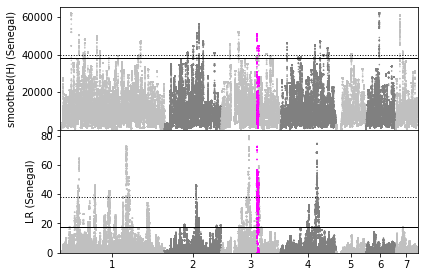

In [ ]:
for pop in ["senegal", "niger", "brazil", "tanzania"]:
#for pop in ["senegal"]:

    csv_file = "./results/selection_peaks/{}_raw_data.csv".format(pop)
    df=pd.read_csv(csv_file, sep=",")
    
    ##########################################################################
    #get points that meet the significance threshold
    percentile = 0.99
    sig_df = df.loc[(df['smoothed_h_perc_rank']> percentile) & (df['lr_perc_rank']> percentile) & (df['h']> max_h[pop]) & (df['lr']> max_lr[pop])]
   
    #individual points need to be merged (i.e. points that overlap or are within 1Mb of each other)
    sig_snp_trees=defaultdict(lambda: IntervalTree()) 
    buffer=1_000_000

    #to start, go through all of the snps that meet the significance threshold and add them to an
    # interval tree with 1Mb on both sides (as a buffer)
    for index, row in sig_df.iterrows():
        sig_snp_trees[row.chrom][row.pos-buffer: row.pos+buffer+1 ] = "sig"

    #now go through each intervaltree (chromosome) and combine overlapping snps (+buffer)
    for chrom in sig_snp_trees.keys():
        sig_snp_trees[chrom].merge_overlaps()

    #to define the peaks we need to extract the merged/overlapping regions and remove the buffer 
    peaks=defaultdict(lambda: IntervalTree()) 

    #...so for each intervaltree/chrom
    for chrom in sig_snp_trees.keys():
        #...and each "peak" (merged region)
        for interval in sig_snp_trees[chrom]:
           #remove the buffer
            begin=interval.begin+buffer
            end=interval.end-buffer

            #and add the final region to the "peaks" interval tree
            peaks[chrom][begin:end]="sig"

    ##########################################################################
    #now we need to find all "non-neutral snps"        
    non_neutral_trees=defaultdict(lambda: IntervalTree()) 
    non_neutral_df  =df.loc[ (df["smoothed_h"]>max_h[pop]) | (df["lr"]>max_lr[pop]) ]

    for index, row in non_neutral_df.iterrows():
        non_neutral_trees[row.chrom][row.pos-buffer: row.pos+buffer+1 ] = "non_neutral"

    non_neutral_peaks=defaultdict(lambda: IntervalTree()) 

    #...so for each intervaltree/chrom
    for chrom in non_neutral_trees.keys():
        non_neutral_trees[chrom].merge_overlaps()
        #...and each "peak" (merged region)
        for interval in non_neutral_trees[chrom]:
           #remove the buffer
            begin=interval.begin+buffer
            end=interval.end-buffer

            #and add the final region to the "peaks" interval tree
            non_neutral_peaks[chrom][begin:end]="non-neutral"       

    ##########################################################################
    peaks_of_selection=defaultdict(lambda: IntervalTree()) 

    for chrom in peaks.keys():
        buffer_tree=IntervalTree()
        #combine all peaks
        union_tree = non_neutral_peaks[chrom] | peaks[chrom]
        #add buffer to each
        for interval in union_tree:
        #add the buffer
            begin=interval.begin-buffer
            end=interval.end+buffer
            buffer_tree[begin:end]="buffer"

        #merge
        buffer_tree.merge_overlaps()

        #get any peaks from the actual peak tree
        for interval in peaks[chrom]:
            #print(buffer_tree[interval.begin:interval.end])
            peaks_of_selection[chrom][interval.begin:interval.end]="peak"
    #..........................................................................

    #now that all of the peaks are defined, we color all snps (wether they meet the sig threhold or not)
    df["color"]="black"
    for index, row in df.iterrows():
        if peaks_of_selection[row["chrom"]].at(row["pos"]):
        #if (peaks[row["chrom"]].at(row["pos"])) or (non_neutral_peaks[row["chrom"]].at(row["pos"])): 
        #        if ( peaks[row["chrom"]].at(row["pos"]) ) #and ( row["h"]> max_h[pop] ) and ( row["lr"]> max_lr[pop] ):
            df.at[index, "color"]= sig_color
        else:
            #chrom_color=get_chrom_color(row)
            df.at[index, "color"]=get_chrom_color(row)
           
    #plot log data for H
    tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]

    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    
    insig_df=df.loc[df.color != sig_color]
    sig_df=df.loc[df.color == sig_color]

    axs[0].scatter(insig_df["fig_x_pos_x"], insig_df['smoothed_h'], marker =".", s = 1, c = insig_df["color"]) 
    axs[0].scatter(sig_df["fig_x_pos_x"],   sig_df['smoothed_h'],   marker =".", s = 1, c = sig_df["color"]) 
    axs[1].scatter(insig_df["fig_x_pos_x"], insig_df['lr'],         marker =".", s = 1, c = insig_df["color"]) 
    axs[1].scatter(sig_df["fig_x_pos_x"],   sig_df['lr'],           marker =".", s = 1, c = sig_df["color"]) 

    #set axes
    axs[0].set_xlim((0,scanned_size))
    axs[0].set_ylim((0,max(df['smoothed_h']*1.05)))
    axs[1].set_ylim((0,max(df['lr']*1.05)))
                    
    plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)
    axs[0].set(ylabel="smoothed(H) ({})".format(pop.title()))
    axs[1].set(ylabel="LR ({})".format(pop.title()))
    axs[0].ticklabel_format(axis='y', style='sci')

    #draw lines at...
    #...the max simulated value
    axs[0].axhline(y=max_h[pop],  color="black", linewidth=1)
    axs[1].axhline(y=max_lr[pop], color="black", linewidth=1)

    #...the 99th percentile
    axs[0].axhline(y=np.percentile(df['smoothed_h'],  percentile*100), linestyle=":",  color="black", linewidth=1)
    axs[1].axhline(y=np.percentile(df['lr'], percentile*100), linestyle=":", color="black", linewidth=1)
    
    #set the title
    #title="{}".format(pop.title())
    #fig.suptitle(title)

    #plt.text(df['fig_x_pos'][-1:], -np.log10(2.056684e-05), 'FDR=0.01', horizontalalignment='right')

    plt.tight_layout()
    fig.savefig("results/selection_peaks/{}_selection.png".format(pop), dpi=300) 
    plt.show()
    plt.close()